In [136]:
import json
import pyspark as ps
from pyspark.sql.types import *
from pyspark.sql.functions import udf, col, when, stddev, mean
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as stats
import re
import time
%matplotlib inline

%load_ext autoreload
%autoreload 2
from src.datadict import dd_to_structure, ageGrouping, hh_income
from src.quick_look import ql, quick_plot
from src.script import welch_satterhwaithe_dof, pop_proportions_test, plot_test_results

plt.rcParams['figure.figsize'] = [30, 15]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Null hypothesis: $H_0: p_{vet} - p_{civ} = 0$ \
 _i.e._, the proportion of the population of employed veterans is equal to the proportion of the larger population of employed civilians (non-veterans).

Alternative hypothesis:
$H_a: p_{vets} - p_{civ} \neq 0$

Rejection region for approximate level $\alpha$ test: 
$z \leq -z_\alpha$ or $z \geq z_\alpha$


Text(0.5, 1.0, 'Distribution of probability')

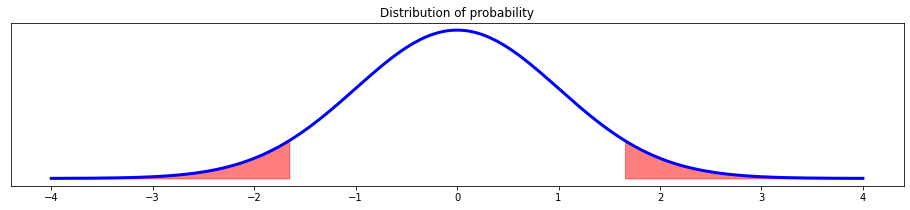

In [149]:
fig, ax = plt.subplots(1, figsize=(16, 3))
dist = stats.norm(0, 1)
x = np.linspace(-4, 4, num=250)
ax.plot(x, dist.pdf(x), linewidth=3, c='b')
ax.fill_between(x, dist.pdf(x), where=(x <= dist.ppf(0.05)),
                color="red", alpha=0.5)
ax.fill_between(x, dist.pdf(x), where=(x >= dist.ppf(0.95)),
                color="red", alpha=0.5)
ax.set_yticks([])
# ax.axvline(diff.ppf(0.95))
ax.set_title("Distribution of probability")

In [48]:
X = 2710
m = 146 + 2710
Y = 47933
n = 2672 + 47933

p_1 = X / m
p_2 = Y / n
p = (X + Y) / (m + n)

z = (p_1 - p_2) / np.sqrt(p * (1 - p) * (1 / m + 1 / n))
z

0.39106018996614794

In [30]:
E = p_1 - p_2
V = (p_1 * (1 - p_1) / m) + (p_2 * (1 - p_2) / n)

(0.0016806584307470507, 1.7972600013668254e-05)

In [91]:
E_vet = stats.norm(p_1, np.sqrt((p_1 * (1 - p_1)) / m))
E_civ = stats.norm(p_2, np.sqrt((p_2 * (1 - p_2)) / n))

Text(0.5, 1.0, 'Distribution of probability of employment')

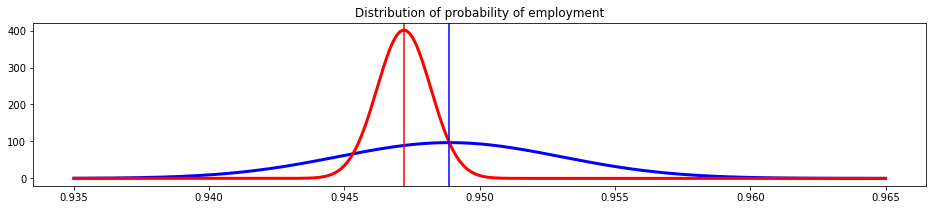

In [62]:
fig, ax = plt.subplots(1, figsize=(16, 3))

x = np.linspace(0.935, 0.965, num=250)
ax.plot(x, E_vet.pdf(x), linewidth=3, c='b')
ax.plot(x, E_civ.pdf(x), linewidth=3, c='r')
# ax.fill_between(x, E_vet.pdf(x), where=(x >= E_vet.mean()),
#                 color="red", alpha=0.5)
ax.axvline(p_1, c='b')
ax.axvline(p_2, c='r')
ax.set_title("Distribution of probability of employment")

## Separating veterans from non-veterans, and counting employed vs unemployed gives:

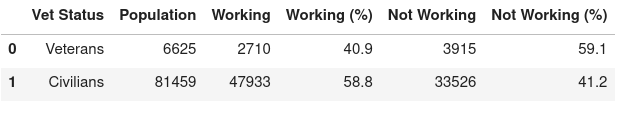

<AxesSubplot:title={'center':'Difference between proportions of veterans and non-veteran working'}>

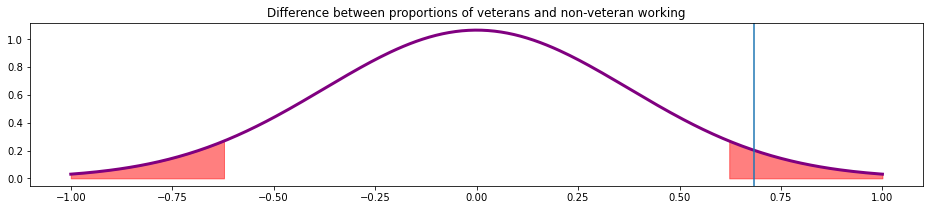

In [151]:
m, X, n, y = 6625, 2710, 81459, 47933
total_p, var, diff, p_value, z_alpha = pop_proportions_test(m, X, n, Y)
title = 'Difference between proportions of veterans and non-veteran working'
fig, ax = plt.subplots(1, figsize=(16, 3))
plot_test_results(ax, diff, p_value, title)

## Correction for NILF
However, the above analysis failed to recognize that "Not Working" != "Unemployed". Looking at the data more closely, respondents can also be categorized as "Not in Labor Force", which would include retirees and students. 

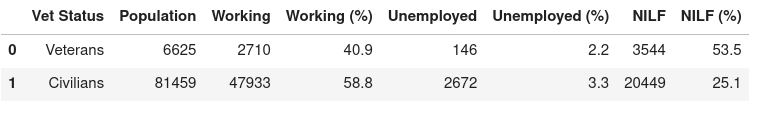

In [152]:
m, X, n, y = 6625-3544, 2710, 81459-20449, 47933
total_p, var, diff, p_value, z_alpha = pop_proportions_test(m, X, n, Y)

<AxesSubplot:title={'center':'Difference between proportions of veterans and non-veteran employed (corrected)'}>

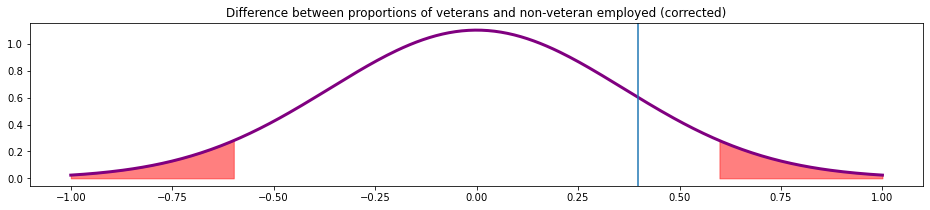

In [155]:
title = 'Difference between proportions of veterans and non-veteran employed (corrected)'
fig, ax = plt.subplots(1, figsize=(16, 3))
plot_test_results(ax, diff, p_value, title)